In [1]:
import sys
sys.path.append('/scratch/ty296/CT_MPS_mini')
from read_hdf5_func import von_neumann_entropy_sv
import h5py
import numpy as np
import os

# Read the HDF5 file
filename = '/scratch/ty296/CT_toy/sv_comparison_L12_pctrl0.000_p0.400-0.600/final_results_L12.h5'


In [2]:
print(sys.path)
print(os.getcwd())

['/projects/community/python/3.9.6/gc563/lib/python39.zip', '/projects/community/python/3.9.6/gc563/lib/python3.9', '/projects/community/python/3.9.6/gc563/lib/python3.9/lib-dynload', '', '/home/ty296/.local/lib/python3.9/site-packages', '/projects/community/python/3.9.6/gc563/lib/python3.9/site-packages', '/scratch/ty296/CT_MPS_mini', '/scratch/ty296/CT_MPS_mini']
/scratch/ty296


In [10]:
h5_file = h5py.File(filename, 'r')
for key in h5_file.keys():
    print(key)
    print(h5_file[key].keys())
    for key2 in h5_file[key].keys():
        print(key2)
        # Check if it's a dataset or group
        dataset = h5_file[key][key2]
        if hasattr(dataset, 'shape'):
            print(f"  Dataset shape: {dataset.shape}")
            print(f"  Dataset dtype: {dataset.dtype}")
            if dataset.size < 100:  # Only print small datasets
                print(f"  Dataset values: {dataset[:]}")
        else:
            print(f"  Group with keys: {list(dataset.keys())}")

pctrl0.000
<KeysViewHDF5 ['haining', 'pproj', 'tao']>
haining
  Group with keys: ['singular_values']
pproj
  Dataset shape: (40,)
  Dataset dtype: float64
  Dataset values: [0.4        0.40512821 0.41025641 0.41538462 0.42051282 0.42564103
 0.43076923 0.43589744 0.44102564 0.44615385 0.45128205 0.45641026
 0.46153846 0.46666667 0.47179487 0.47692308 0.48205128 0.48717949
 0.49230769 0.4974359  0.5025641  0.50769231 0.51282051 0.51794872
 0.52307692 0.52820513 0.53333333 0.53846154 0.54358974 0.54871795
 0.55384615 0.55897436 0.56410256 0.56923077 0.57435897 0.57948718
 0.58461538 0.58974359 0.59487179 0.6       ]
tao
  Group with keys: ['singular_values']


(40,)
(40,)


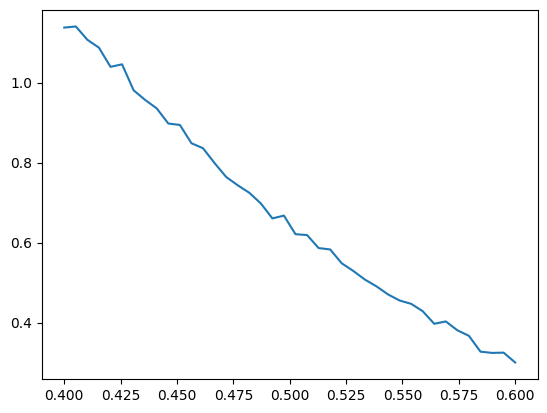

In [48]:
print(s0_ave_data.shape)
print(p_proj_values.shape)
# print(s0_ave_data.dtype)
# print(s0_ave_data.size)
# print(s0_ave_data.ndim)
# print(s0_ave_data.nbytes)
# print(s0_ave_data.nbytes)

import matplotlib.pyplot as plt
plt.plot(p_proj_values[:], s0_ave_data[:])
plt.show()


In [ ]:
import glob
import os
from functools import partial
from read_hdf5_func import calculate_mean_and_error, calculate_variance_and_error

SvN_fixed = partial(von_neumann_entropy_sv, n=0, positivedefinite=False, threshold=1e-15)

# Pattern to match folders
pattern = "/scratch/ty296/CT_toy/sv_comparison_L*_pctrl0.000_p0.400-0.600/final_results_L*.h5"
folders = glob.glob(pattern)

# extract L values from folder names
from pathlib import Path
import re
L_values = [int(re.search(r'L(\d+)', p.name).group(1)) for p in Path("/scratch/ty296/CT_toy").glob("sv_comparison_L*_pctrl0.000_p0.400-0.600")]

# Create increasingly deeper shades of blue proportional to L value
# Smaller L = very light blue, larger L = darker blue
colors = []
min_L = min(L_values)
max_L = max(L_values)

for L in L_values:
    # Normalize L to range [0, 1]
    norm_L = (L - min_L) / (max_L - min_L)
    
    # Create light blue to dark blue gradient
    # Light blue: (0.7, 0.7, 1.0), Dark blue: (0.0, 0.0, 0.8)
    red = 0.7 * (1 - norm_L)      # From 0.7 to 0.0
    green = 0.7 * (1 - norm_L)    # From 0.7 to 0.0  
    blue = 1.0 - 0.2 * norm_L     # From 1.0 to 0.8
    
    blue_color = (red, green, blue)
    
    colors.append(blue_color)

# Organize data by L values
plot_data = {}
for L in L_values:
    plot_data[L] = {'p_proj': [], 'mean': [], 'sem': [], 'variance': [], 'se_var': []}

for filename, L in zip(folders, L_values):
    h5_file = h5py.File(filename, 'r')
    data_set = h5_file['pctrl0.000']['tao']['singular_values']['AB']
    p_proj_values = h5_file['pctrl0.000']['pproj']

    raw_s0_data = np.apply_along_axis(SvN_fixed, axis=2, arr=data_set)
    s0_mean_data = np.apply_along_axis(calculate_mean_and_error, axis=1, arr=raw_s0_data)
    s0_var_data = np.apply_along_axis(calculate_variance_and_error, axis=1, arr=raw_s0_data)
    plot_data[L]['p_proj'] = p_proj_values[:]
    plot_data[L]['mean'] = s0_mean_data[:,0]
    plot_data[L]['sem'] = s0_mean_data[:,1]
    plot_data[L]['variance'] = s0_var_data[:,0]
    plot_data[L]['se_var'] = s0_var_data[:,1]


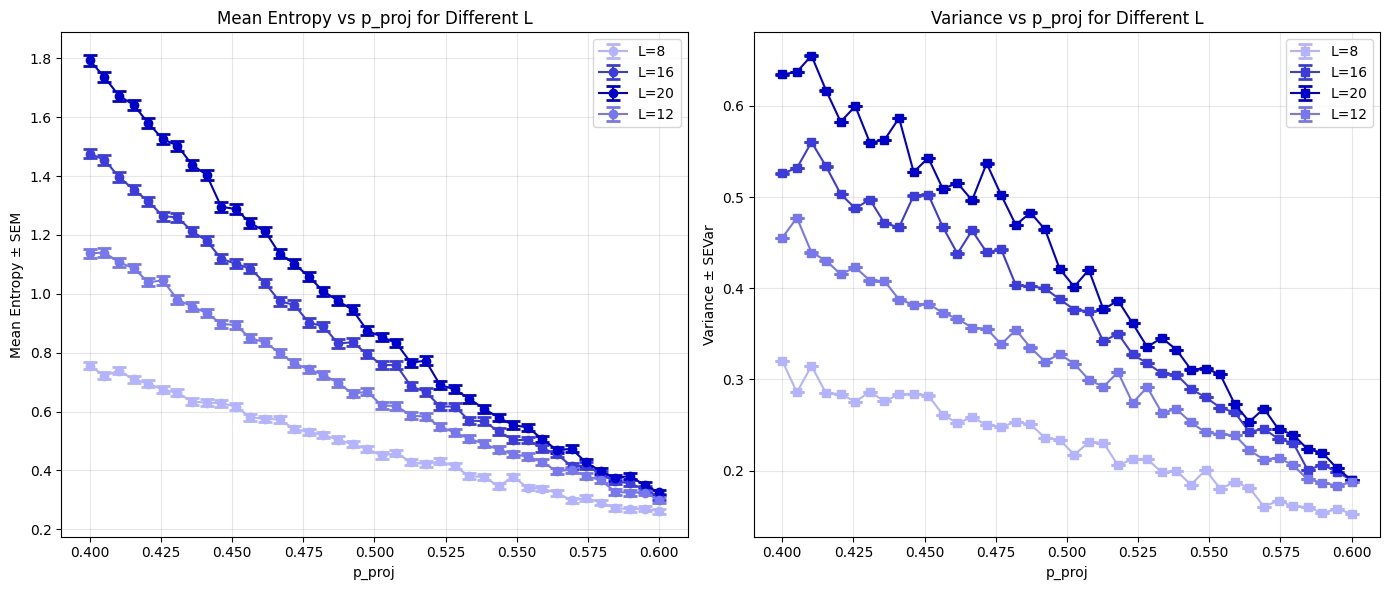

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: p_proj vs mean ± sem
for i, L in enumerate(L_values):
    ax1.errorbar(plot_data[L]['p_proj'], plot_data[L]['mean'], yerr=plot_data[L]['sem'], 
                label=f'L={L}', marker='o', capsize=5, capthick=2, color=colors[i])

ax1.set_xlabel('p_proj')
ax1.set_ylabel('Mean Entropy ± SEM')
ax1.set_title('Mean Entropy vs p_proj for Different L')
ax1.legend()
# ax1.set_xlim(0.2, 1.0)
ax1.grid(True, alpha=0.3)

# Plot 2: p_proj vs variance ± se_var
for i, L in enumerate(L_values):
    data = plot_data[L]
    
    ax2.errorbar(data['p_proj'], data['variance'], yerr=data['se_var'], 
                label=f'L={L}', marker='s', capsize=5, capthick=2, color=colors[i])

ax2.set_xlabel('p_proj')
ax2.set_ylabel('Variance ± SEVar')
ax2.set_title('Variance vs p_proj for Different L')
ax2.legend()
# ax2.set_xlim(0.2, 1.0)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig(f'{self.save_folder}/s{self.n}_threshold{threshold:.1e}_{self.p_fixed_name}{self.p_fixed_value}.png')
# print(f'threshold {threshold} saved to {self.save_folder}/s{self.n}_threshold{threshold:.1e}_{self.p_fixed_name}{self.p_fixed_value}.png')
plt.show()

8388608